In [1]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import scanpy as sc
from time import time

import scvelo as scv
scv.logging.print_versions()

scvelo==0.1.24  scanpy==1.4.5.dev136+gd8f32c0  anndata==0.6.22.post2.dev82+g6310e3e  loompy==3.0.0  numpy==1.17.2  scipy==1.3.1  matplotlib==3.0.3  sklearn==0.21.3  pandas==0.25.1  


In [2]:
scv.settings.set_figure_params(style='scvelo')
scv.settings.verbosity = 0

In [3]:
def run_scv(adata, mode='steady_state'):
    scv.pp.filter_and_normalize(adata, min_counts=20, min_counts_u=10, n_top_genes=1000)
    scv.pp.moments(adata, method='hnsw', n_pcs=30, n_neighbors=30)
    
    if mode is 'dynamical':
        scv.tl.velocity(adata, mode="steady_state", filter_genes=True)
        scv.tl.recover_dynamics(adata)
        scv.tl.velocity(adata, mode=mode)  
    else:
        scv.tl.velocity(adata, mode=mode, filter_genes=True)
    try:
        scv.tl.velocity_graph(adata)
        scv.tl.velocity_embedding(adata)
    except:
        print("neighbor graph corrupted")
    
def run_vcy(vlm):
    vlm.score_detection_levels(min_expr_counts=20, min_expr_counts_U=10)
    vlm.filter_genes(by_detection_levels=True)
    
    if vlm.S.shape[0] > 1000:
        vlm.score_cv_vs_mean(1000)
        vlm.filter_genes(by_cv_vs_mean=True)

    vlm._normalize_S(relative_size=vlm.initial_cell_size, target_size=np.median(vlm.initial_cell_size))
    vlm._normalize_U(relative_size=vlm.initial_Ucell_size, target_size=np.median(vlm.initial_Ucell_size))

    vlm.S_norm = np.log1p(vlm.S_sz)

    vlm.perform_PCA(n_components=30)
    vlm.knn_imputation(n_pca_dims=30, k=30)
    vlm.normalize_median()
    
    vlm.fit_gammas()
    vlm.filter_genes_good_fit()
    
    vlm.predict_U()
    vlm.calculate_velocity()
    vlm.calculate_shift()
    vlm.extrapolate_cell_at_t()
    
    vlm.estimate_transition_prob()
    vlm.calculate_embedding_shift()
    vlm.calculate_grid_arrows()

In [5]:
adata_ref = scv.read('data/pancreas/endocrinogenesis.h5ad')

In [6]:
test = False

In [6]:
#scvelo's steady-state and stochastic model
np.random.seed(42)
n_cells = np.array([1e3, 5e3, 10e3, 15e3, 20e3, 25919, 30e3, 35e3, 40e3, 50e3, 60e3], dtype=int)
if test: n_cells = np.array([.5e3, 1e3], dtype=int)
scv_stoch_time, scv_time = [], []

for n in n_cells:
    indices = np.random.choice(adata_ref.n_obs, n)
    adata = adata_ref[indices]
    adata.obs_names_make_unique()
    
    scv.utils.cleanup(adata, clean='all')
    
    adata_run = adata.copy()
    t_init = time()
    run_scv(adata_run)
    scv_time.extend([(time() - t_init) / 60])
    
    adata_run = adata.copy()
    t_init = time()
    run_scv(adata_run, mode='stochastic')
    scv_stoch_time.extend([(time() - t_init) / 60])
    
    np.save('data/runtime/scv_time' + str(n), scv_time[-1])
    np.save('data/runtime/scv_stoch_time' + str(n), scv_stoch_time[-1])

scv_time = np.array(scv_time)
scv_stoch_time = np.array(scv_stoch_time)

np.save('data/runtime/n_cells', n_cells)
np.save('data/runtime/scv_time', scv_time)
np.save('data/runtime/scv_stoch_time', scv_stoch_time)

In [7]:
#velocyto's steady-state model
np.random.seed(42)
n_cells = np.array([1e3, 5e3, 10e3, 15e3, 20e3, 25919, 30e3, 35e3, 40e3, 50e3, 60e3], dtype=int)  # run out of 64GB RAM at 40k cells
if test: n_cells = np.array([.5e3, 1e3], dtype=int)
vcy_time = []

for n in n_cells:
    indices = np.random.choice(adata_ref.n_obs, n)
    adata = adata_ref[indices]
    adata.obs_names_make_unique()
    
    scv.utils.cleanup(adata, clean='all')
    adata_run = adata.copy()
    vlm = scv.utils.convert_to_loom(adata_run, basis='umap')
    
    t_init = time()
    run_vcy(vlm)
    vcy_time.extend([(time() - t_init) / 60])
    
    np.save('data/runtime/vcy_time' + str(n), vcy_time[-1])

vcy_time = np.array(vcy_time)
np.save('data/runtime/vcy_time', vcy_time)

KeyboardInterrupt: 

In [10]:
vcy_time = np.array(vcy_time)
np.save('data/runtime/vcy_time', vcy_time)

In [7]:
#scvelo's dynamical model
np.random.seed(42)
n_dyn_cells = np.array([1e3, 10e3, 20e3, 25919, 30e3, 40e3, 60e3], dtype=int)
if test: n_dyn_cells = np.array([.5e3, 1e3], dtype=int)
scv_dyn_time = []

for n in n_dyn_cells:
    indices = np.random.choice(adata_ref.n_obs, n)
    adata = adata_ref[indices]
    adata.obs_names_make_unique()
    
    scv.utils.cleanup(adata, clean='all')
    
    adata_run = adata.copy()
    t_init = time()
    run_scv(adata_run, mode='dynamical')
    scv_dyn_time.extend([(time() - t_init) / 60])
    
    np.save('data/runtime/scv_dyn_time' + str(n), scv_dyn_time[-1])
    
scv_dyn_time = np.array(scv_dyn_time)
np.save('data/runtime/n_dyn_cells', n_dyn_cells)
np.save('data/runtime/scv_dyn_time', scv_dyn_time)

In [9]:
#scvelo's steady-state and stochastic model second run with large cell numbers
np.random.seed(2020)
n_large_cells = np.array([100e3, 150e3, 200e3, 250e3, 300e3], dtype=int)
if test: n_large_cells = np.array([.5e3, 1e3], dtype=int)
scv_stoch_large_time, scv_large_time = [], []

for n in n_large_cells:
    indices = np.random.choice(adata_ref.n_obs, n)
    adata = adata_ref[indices]
    adata.obs_names_make_unique()
    
    scv.utils.cleanup(adata, clean='all')
    
    adata_run = adata.copy()
    t_init = time()
    run_scv(adata_run)
    scv_large_time.extend([(time() - t_init) / 60])
    
    adata_run = adata.copy()
    t_init = time()
    run_scv(adata_run, mode='stochastic')
    scv_stoch_large_time.extend([(time() - t_init) / 60])
    
    np.save('data/runtime/scv_large_time' + str(n), scv_large_time[-1])
    np.save('data/runtime/scv_stoch_large_time' + str(n), scv_stoch_large_time[-1])

scv_large_time = np.array(scv_large_time)
scv_stoch_large_time = np.array(scv_stoch_large_time)
np.save('data/runtime/n_large_cells', n_large_cells)
np.save('data/runtime/scv_large_time', scv_large_time)
np.save('data/runtime/scv_stoch_large_time', scv_stoch_large_time)

In [4]:
n_cells = scv.load('data/runtime/n_cells.npy')
scv_time = scv.load('data/runtime/scv_time.npy')
scv_stoch_time = scv.load('data/runtime/scv_stoch_time.npy')
vcy_time = scv.load('data/runtime/vcy_time.npy')

n_dyn_cells = scv.load('data/runtime/n_dyn_cells.npy')
scv_dyn_time = scv.load('data/runtime/scv_dyn_time.npy')

n_large_cells = scv.load('data/runtime/n_large_cells.npy')
scv_large_time = scv.load('data/runtime/scv_large_time.npy')
scv_stoch_large_time = scv.load('data/runtime/scv_stoch_large_time.npy')

In [6]:
vcy_time_ext = np.hstack([vcy_time, np.ones(len(n_cells) - len(vcy_time))*np.nan])
pd.DataFrame(np.vstack([n_cells, scv_time, scv_stoch_time, vcy_time_ext]).T.round(2), 
             columns=['n_cells', 'scvelo steady-state', 'scvelo stochastic', 'velocyto steady-state'])

,n_cells,scvelo steady-state,scvelo stochastic,velocyto steady-state
0,1000.0,0.05,0.02,0.06
1,5000.0,0.10,0.17,0.41
2,10000.0,0.25,0.38,1.33
3,15000.0,0.40,0.59,2.91
4,20000.0,0.53,0.76,5.10
5,25919.0,0.64,0.91,8.39
6,30000.0,0.71,1.00,14.26
7,35000.0,0.82,1.15,27.13
8,40000.0,0.87,1.21,NaN
9,50000.0,0.98,1.34,NaN


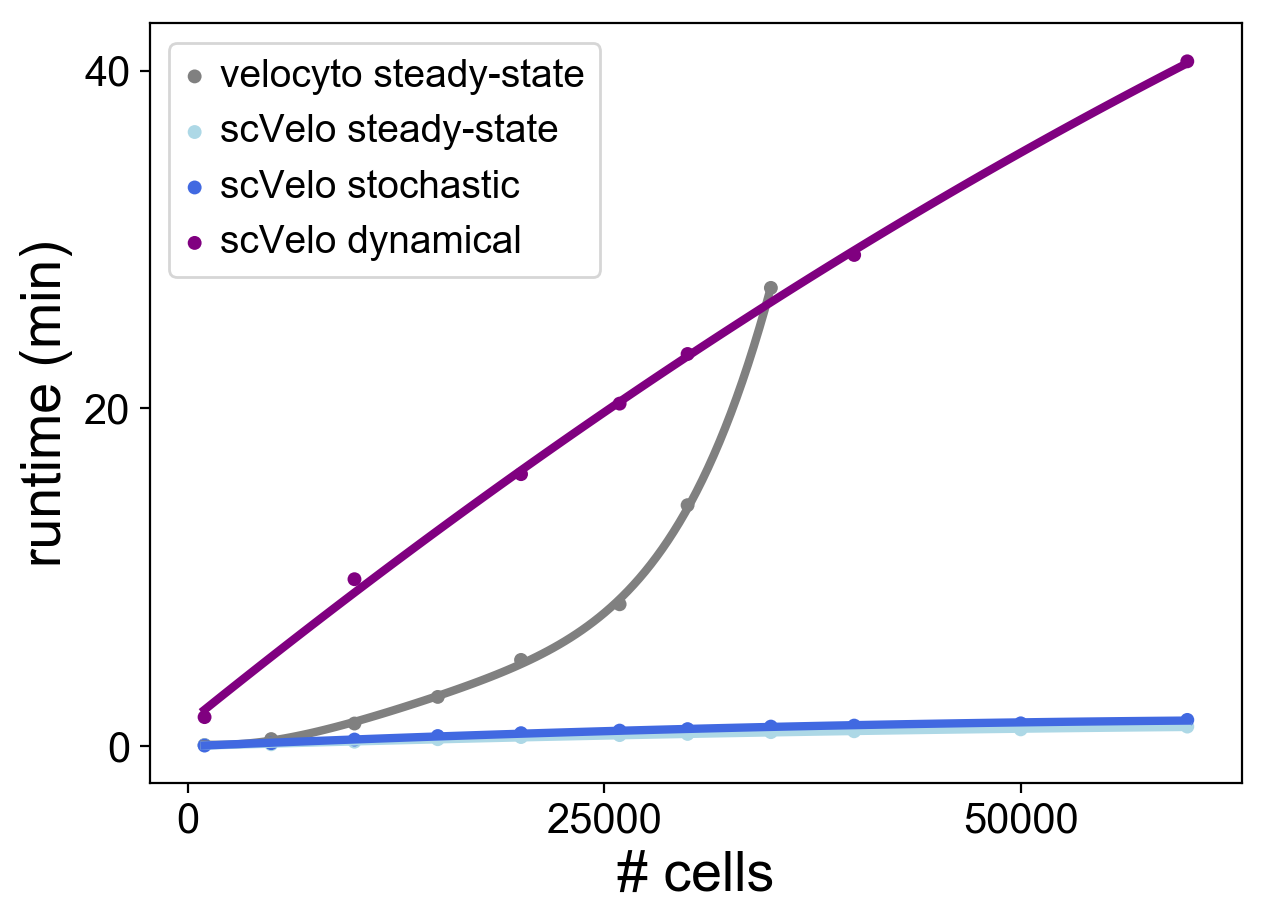

In [7]:
kwargs = {'show': False, 'fontsize': 20, 'size': 100, 'linewidth': 3}
labels = ['velocyto steady-state', 'scVelo steady-state',
          'scVelo stochastic', 'scVelo dynamical']

ax = scv.pl.scatter(x=n_cells[:len(vcy_time)], y=vcy_time, **kwargs, show_polyfit=5, label=labels[0])
ax = scv.pl.scatter(x=n_cells, y=scv_time, color='lightblue', ax=ax, **kwargs, show_polyfit=True, label=labels[1])
ax = scv.pl.scatter(x=n_cells, y=scv_stoch_time, ax=ax, color='royalblue', **kwargs, show_polyfit=True, label=labels[2])
ax = scv.pl.scatter(x=n_dyn_cells, y=scv_dyn_time, ax=ax, color='purple', **kwargs, show_polyfit=True, label=labels[3])

pl.legend(fontsize=14)
pl.xlabel('# cells', fontsize=20);
pl.ylabel('runtime (min)', fontsize=20);

complexity:  0.6825109901178577


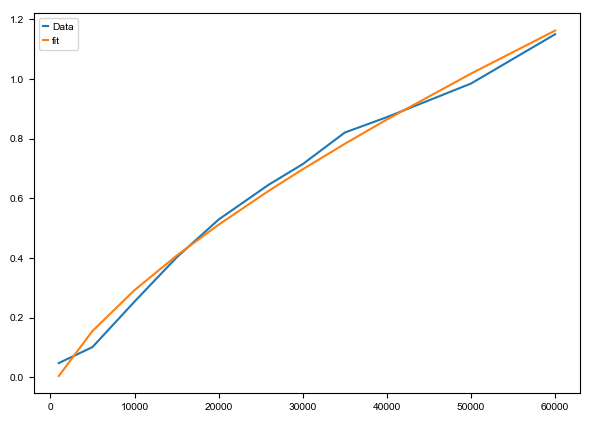

complexity:  0.8324485537356342


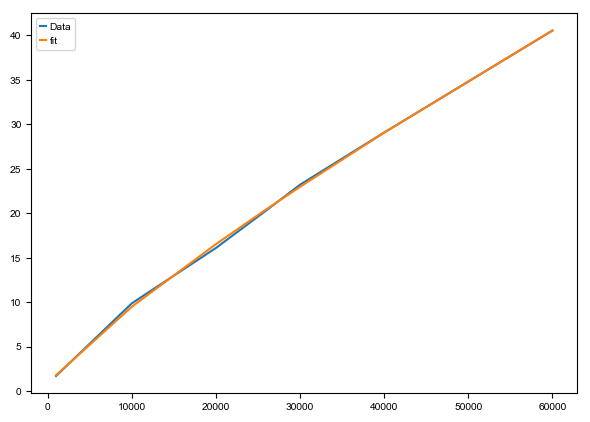

complexity:  3.9414349162779394


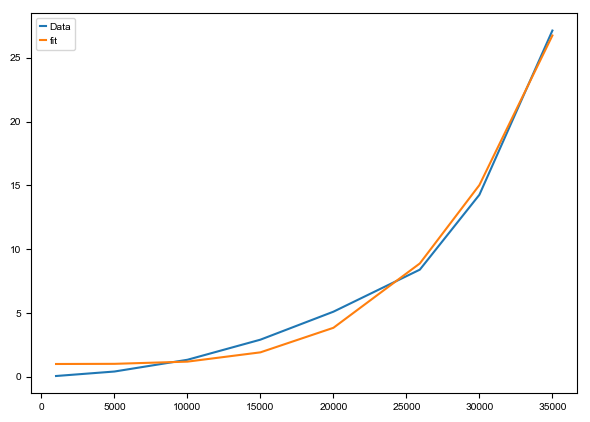

In [8]:
from scipy.optimize import curve_fit

def expo(x, a, b, c):
        o = 1 if np.isscalar(x) else np.ones(len(x))
        return a * x ** b + c * o
    
def fit(x, y, n_extrapol=None):
    def do_fit(function, x, y):
        popt, pcov = curve_fit(eval(function), x, y, maxfev=10000)
        print('complexity: ', popt[1])
        #print('Standard error fit: ', np.sqrt(np.diag(pcov)))
        return popt, pcov
    
    ax=pl.figure(dpi=50).gca()
    x = np.array(x)
    ax.plot(x, y)

    popt, pcov = do_fit('expo', x, y)
    ax.plot(x, expo(x, popt[0], popt[1], popt[2]))
    pl.legend(['Data', 'fit'])
    
    pl.show()
    if n_extrapol is not None: 
        return expo(n_extrapol, popt[0], popt[1], popt[2])
    
fit(n_cells, scv_time)
fit(n_dyn_cells, scv_dyn_time)
fit(n_cells[:len(vcy_time)], vcy_time)